In [1]:
# c_param 10, no heuristic

In [1]:
import numpy as np
from collections import defaultdict
from itertools import product
import time
import pdb

# Pickle (for Pre-trained Model)

In [3]:
import pickle

### Writer

In [20]:
comment = "50mil training, no heuristic to always pick immediate mate, fixed rewards, c_param=10"
model = [root, comment]

file_name = 'MCTS_root_feb6_1928.txt'
with open(file_name,'wb') as f:
    pickle.dump(model,f)


### Loader

In [4]:
with open('MCTS_root_feb6_1928.txt', 'rb') as f:
    [loaded_root, loaded_comment] = pickle.load(f)
    print(loaded_root)
    print(loaded_comment)

50mil training, no heuristic to always pick immediate mate, fixed rewards, c_param=10


# Model

In [2]:
class MonteCarloTreeSearchNode:
    def __init__(self, state, parent=None, parent_action=None):
        self.state = state
        self.parent = parent
        self.parent_action = parent_action
        self.children = np.array([], dtype=MonteCarloTreeSearchNode)
        self._number_of_visits = 0
        self._results = defaultdict(int)
        self._results[1] = 0
        self._results[0] = 0
        self._results[-1] = 0
        self._untried_actions = None
        self._untried_actions = self.untried_actions()
        if len(self._untried_actions) % 2 == 0:
            self.player = 1
        else:
            self.player = -1
        self.batch_evaluation = []
    
    def untried_actions(self):
        self._untried_actions = self.get_legal_actions()
        return self._untried_actions

    def q(self):
        wins = self._results[1]
        ties = self._results[0]
        return wins + 0.5*ties

    def n(self):
        return self._number_of_visits
    
    def expand(self):   
        action = self._untried_actions[0]
        self._untried_actions = np.delete(self._untried_actions, 0, 0)
        next_state = self.move(action)
        child_node = MonteCarloTreeSearchNode(next_state, parent=self, parent_action=action)

        self.children = np.append(self.children, child_node)
        return child_node 
    
    def is_terminal_node(self):
        return self.game_result(self.state) is not None
    
    def rollout(self):
        current_rollout_state = np.copy(self.state)
        result = self.game_result(current_rollout_state)
        next_player = -self.player
        while result is None:

            possible_moves = self.get_legal_actions(current_rollout_state)

            action = self.rollout_policy(possible_moves)
            current_rollout_state = self.move(action, current_rollout_state, next_player)
            next_player = -next_player
            result = self.game_result(current_rollout_state)
        return result

    def backpropagate(self, result):
        self._number_of_visits += 1.
        self._results[result] += 1.
        if self.parent:
            # negative result to alternate between players
            self.parent.backpropagate(-result)

    def is_fully_expanded(self):
        return len(self._untried_actions) == 0
    
    def best_child(self, c_param=10):
        choices_weights = [(c.q() / c.n()) + c_param * np.sqrt((2 * np.log(self.n())) / c.n()) for c in self.children]
        return self.children[np.argmax(choices_weights)]
    
    def rollout_policy(self, possible_moves):
        return np.array(possible_moves[np.random.randint(len(possible_moves))])
    
    def _tree_policy(self):
        current_node = self
        while not current_node.is_terminal_node():

            if not current_node.is_fully_expanded():
                return current_node.expand()
            else:
                current_node = current_node.best_child()
        return current_node
    
    def get_legal_actions(self, given_state=None): 
        if given_state is None:
            s = self.state
        else:
            s = given_state
            
        legal_actions = np.empty([0,2],dtype=int)
        for row, col in product(range(3),range(3)):
            if s[row][col] == 0:
                legal_actions = np.append(legal_actions,[[row,col]], axis=0)
        return legal_actions
        
    def game_result(self, given_state=None):
        if given_state is None:
            s = self.state
        else:
            s = given_state
        #check if rows and cols
        if s[0][0] == s[0][1] == s[0][2] != 0: 
            return s[0][0]
        elif s[1][0] == s[1][1] == s[1][2] != 0: 
            return s[1][0]
        elif s[2][0] == s[2][1] == s[2][2] != 0:
            return s[2][0]
        elif s[0][0] == s[1][0] == s[2][0] != 0: 
            return s[0][0]
        elif s[0][1] == s[1][1] == s[2][1] != 0: 
            return s[0][1]
        elif s[0][2] == s[1][2] == s[2][2] != 0:
            return s[0][2]
        
        #check diagonals
        elif s[0][0] == s[1][1] == s[2][2] != 0:
            return s[0][0] 
        elif s[0][2] == s[1][1] == s[2][0] != 0:
            return s[0][2]
        
        #check if board is full
        elif len(self.get_legal_actions(s)) == 0:
            return 0
        else:
            return None
        
        
    def move(self,action,given_state=None, next_player=None):
        if given_state is None:
            new_state = np.copy(self.state)
        else:
            new_state = np.copy(given_state)
        if next_player is None:
            # -self.player since opponent will be making this move on expand()
            next_player = -self.player
        new_state[action[0]][action[1]] = next_player
        return new_state
    
    def get_player(self):
        return self.player
    
    def train(self, rollouts_to_run, rollouts_sofar):
        # time prints variables
        total_rollouts = rollouts_to_run + rollouts_sofar
        batch_size = 10000
        batches_remaining = rollouts_to_run/batch_size
        batch_time = 0
        start = time.perf_counter()
        
        for i in range(rollouts_to_run):
            # ----time prints calls----
            rollouts_sofar += 1
            if (rollouts_sofar+1) % batch_size == 0:
                prev_batch_time = batch_time
                batch_time = (time.perf_counter()-start)/60 
                start = time.perf_counter()
                batches_remaining -= 1
                time_remaining = batch_time * batches_remaining
                batch_time_diff = batch_time - prev_batch_time
                # [x_wins,ties,o_wins] per batch
                self.batch_evaluation.append([self._results[-1],self._results[0],self._results[1]])
                print(f"rollouts_ran: {rollouts_sofar + 1}/{total_rollouts}, time_remaining: {time_remaining:.2f} min, batch_time_diff: {(batch_time_diff * 60):.2f} sec             ", end='\r')
            # -------------------------
            
            v = self._tree_policy()
            winner = v.rollout()
            if winner == 0:
                v.backpropagate(0)
            else:
                v.backpropagate(1 if winner == v.player else -1)
                
        
        print("\ndone")
        return rollouts_sofar

# Train

In [4]:
initial_state = np.zeros((3,3),int)
root = MonteCarloTreeSearchNode(initial_state)
rollouts_sofar = 0

In [5]:
start = time.perf_counter()
rollouts_sofar = root.train(50000000, rollouts_sofar)
training_time = time.perf_counter() - start
print("total training time: ", training_time/60, "min")

rollouts_ran: 50000000/50000000, time_remaining: 0.00 min, batch_time_diff: 0.05 sec                
done
total training time:  469.43552361999997 min


# batch_eval

batch


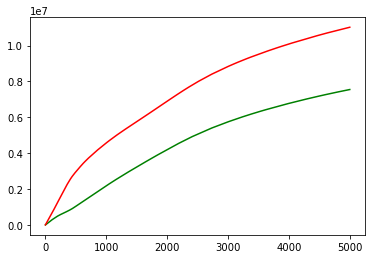

In [6]:
from matplotlib import pyplot as plt
wins = []
ties = []
losses = []
x_list = [i for i in range(5000)]
print("batch")
for i, batch in enumerate(root.batch_evaluation):
    losses.append(batch[0])
    ties.append(batch[1])
    wins.append(batch[2])

plt.plot(x_list, wins, color='green')
plt.plot(losses, color='red')
plt.show()

# Nodes found

In [7]:
#bfs
queue = [root]
count = 0
while queue:
    count += 1
    node = queue.pop(0)
#     print(node.state)
    for c in node.children:
        queue.append(c)
print(count)

549946


## Test Perfect Game

In [24]:
curr = root
while curr.game_result() is None:
    print(curr.state)
    print(curr._results)
    print()
    visits = {}
    ratios = {}
    max_visits = -1
    max_ratio = -1
 
    # MAX VISITS
    for c in curr.children:
        print(c.parent_action, c._number_of_visits, (c.q() / c.n()) + np.sqrt((2 * np.log(curr.n()) / c.n())))
        if c._number_of_visits >= max_visits:
            max_visits = c._number_of_visits
            if max_visits in visits:
                visits[max_visits].append(c)
            else:
                visits[max_visits] = [c]
        if len(visits[max_visits]) > 1:
            child = visits[max_visits][np.random.randint(0,len(visits[max_visits]))]
        else:
            child = visits[max_visits][0]
    curr = child

    # BEST_CHILD
#     curr = curr.best_child()

print(curr.state)
print(curr._results)

[[0 0 0]
 [0 0 0]
 [0 0 0]]
defaultdict(<class 'int'>, {1: 7547466.0, 0: 31434519.0, -1: 11018015.0})

[0 0] 3796520.0 0.5309924554721468
[0 1] 3725391.0 0.5307310775753357
[0 2] 3798396.0 0.5309992278784591
[1 0] 3725804.0 0.5307326732301141
[1 1] 19908921.0 0.5464856058339734
[1 2] 3726535.0 0.5307354001226645
[2 0] 3796196.0 0.5309912823190839
[2 1] 3725705.0 0.5307322410529242
[2 2] 3796532.0 0.5309924940405619
[[0 0 0]
 [0 1 0]
 [0 0 0]]
defaultdict(<class 'int'>, {1: 2853630.0, 0: 15999481.0, -1: 1055810.0})

[0 0] 17534672.0 0.4828531463238637
[0 1] 153675.0 0.22265678096347752
[0 2] 586542.0 0.2834242566713172
[1 0] 153657.0 0.22264945759000043
[1 2] 153729.0 0.2226787404898417
[2 0] 586632.0 0.2834290850169817
[2 1] 153527.0 0.22259723778757684
[2 2] 586486.0 0.2834211189803684
[[-1  0  0]
 [ 0  1  0]
 [ 0  0  0]]
defaultdict(<class 'int'>, {1: 660922.0, 0: 15562944.0, -1: 1310806.0})

[0 1] 3718087.0 0.527628593434803
[0 2] 2205033.0 0.5195807170993539
[1 0] 3718062.0 0.52762

# GUI

In [5]:
from tkinter import *
import numpy as np
import time


size_of_board = 600
symbol_size = (size_of_board / 3 - size_of_board / 8) / 2
symbol_thickness = 50
symbol_X_color = '#EE4035'
symbol_O_color = '#0492CF'
win_line_color = '#000000'
Green_color = '#7BC043'


class Tic_Tac_Toe():
    # ------------------------------------------------------------------
    # Initialization Functions:
    # ------------------------------------------------------------------
    def __init__(self, root, player_first):
        self.window = Tk()
        self.window.title('Tic-Tac-Toe')
        self.canvas = Canvas(self.window, width=size_of_board, height=size_of_board)
        self.canvas.pack()
        # Input from user in form of clicks
        self.window.bind('<Button-1>', self.click)

        self.board_status = np.zeros(shape=(3, 3))

        self.player_X_starts = True if player_first else False
        self.reset_board = False
        self.gameover = False
        self.tie = False
        self.X_wins = False
        self.O_wins = False

        self.X_score = 0
        self.O_score = 0
        self.tie_score = 0
        
        self.root = root
        self.curr = root
        self.initialize_board()

    def mainloop(self):
        self.window.mainloop()

    def initialize_board(self):
        for i in range(2):
            self.canvas.create_line((i + 1) * size_of_board / 3, 0, (i + 1) * size_of_board / 3, size_of_board)

        for i in range(2):
            self.canvas.create_line(0, (i + 1) * size_of_board / 3, size_of_board, (i + 1) * size_of_board / 3)
            
        if not self.player_X_starts:
            max_visits = -1
            visits = {}
            for c in self.curr.children:
                if c._number_of_visits >= max_visits:
                    max_visits = c._number_of_visits
                    if max_visits in visits:
                        visits[max_visits].append(c)
                    else:
                        visits[max_visits] = [c]
                if len(visits[max_visits]) > 1:
                    child = visits[max_visits][np.random.randint(0,len(visits[max_visits]))]
                else:
                    child = visits[max_visits][0]
            self.curr = child
            AI_logical_pos = np.array([self.curr.parent_action[1],self.curr.parent_action[0]])
            print("AI    ", AI_logical_pos)
            self.draw_O(AI_logical_pos)
            self.board_status[AI_logical_pos[0]][AI_logical_pos[1]] = 1

    def play_again(self):
        self.curr = self.root
        self.board_status = np.zeros(shape=(3, 3))
        self.initialize_board()

    # ------------------------------------------------------------------
    # Drawing Functions:
    # The modules required to draw required game based object on canvas
    # ------------------------------------------------------------------

    def draw_O(self, logical_position):
        logical_position = np.array(logical_position)
        # logical_position = grid value on the board
        # grid_position = actual pixel values of the center of the grid
        grid_position = self.convert_logical_to_grid_position(logical_position)
        self.canvas.create_oval(grid_position[0] - symbol_size, grid_position[1] - symbol_size,
                                grid_position[0] + symbol_size, grid_position[1] + symbol_size, width=symbol_thickness,
                                outline=symbol_O_color)

    def draw_X(self, logical_position):
        grid_position = self.convert_logical_to_grid_position(logical_position)
        self.canvas.create_line(grid_position[0] - symbol_size, grid_position[1] - symbol_size,
                                grid_position[0] + symbol_size, grid_position[1] + symbol_size, width=symbol_thickness,
                                fill=symbol_X_color)
        self.canvas.create_line(grid_position[0] - symbol_size, grid_position[1] + symbol_size,
                                grid_position[0] + symbol_size, grid_position[1] - symbol_size, width=symbol_thickness,
                                fill=symbol_X_color)

    def display_gameover(self):

        if self.X_wins:
            self.X_score += 1
            text = 'Winner: Player 1 (X)'
            color = symbol_X_color
        elif self.O_wins:
            self.O_score += 1
            text = 'Winner: AI (O)'
            color = symbol_O_color
        else:
            self.tie_score += 1
            text = 'Its a tie'
            color = 'gray'

        self.canvas.delete("all")
        self.canvas.create_text(size_of_board / 2, size_of_board / 3, font="cmr 40 bold", fill=color, text=text)

        score_text = 'Scores \n'
        self.canvas.create_text(size_of_board / 2, 5 * size_of_board / 8, font="cmr 40 bold", fill=Green_color,
                                text=score_text)

        score_text = 'Player 1 (X) : ' + str(self.X_score) + '\n'
        score_text += 'AI (O)           : ' + str(self.O_score) + '\n'
        score_text += 'Tie                : ' + str(self.tie_score)
        self.canvas.create_text(size_of_board / 2, 3 * size_of_board / 4, font="cmr 30 bold", fill=Green_color,
                                text=score_text)
        self.reset_board = True
        self.gameover = False

        score_text = 'Click to play again \n'
        self.canvas.create_text(size_of_board / 2, 15 * size_of_board / 16, font="cmr 20 bold", fill="gray",
                                text=score_text)

    # ------------------------------------------------------------------
    # Logical Functions:
    # The modules required to carry out game logic
    # ------------------------------------------------------------------

    def convert_logical_to_grid_position(self, logical_position):
        logical_position = np.array(logical_position, dtype=int)
        return (size_of_board / 3) * logical_position + size_of_board / 6

    def convert_grid_to_logical_position(self, grid_position):
        grid_position = np.array(grid_position)
        return np.array(grid_position // (size_of_board / 3), dtype=int)

    def is_grid_occupied(self, logical_position):
        if self.board_status[logical_position[0]][logical_position[1]] == 0:
            return False
        else:
            return True

    def is_winner(self, player):

        player = -1 if player == 'X' else 1

        # Three in a row
        for i in range(3):
            if self.board_status[i][0] == self.board_status[i][1] == self.board_status[i][2] == player:
                return True
            if self.board_status[0][i] == self.board_status[1][i] == self.board_status[2][i] == player:
                return True

        # Diagonals
        if self.board_status[0][0] == self.board_status[1][1] == self.board_status[2][2] == player:
            return True

        if self.board_status[0][2] == self.board_status[1][1] == self.board_status[2][0] == player:
            return True

        return False

    def is_tie(self):

        r, c = np.where(self.board_status == 0)
        tie = False
        if len(r) == 0:
            tie = True

        return tie

    def is_gameover(self):
        # Either someone wins or all grid occupied
        self.X_wins = self.is_winner('X')
        if not self.X_wins:
            self.O_wins = self.is_winner('O')

        if not self.O_wins:
            self.tie = self.is_tie()

        gameover = self.X_wins or self.O_wins or self.tie

        if self.X_wins:
            print('X wins')
        if self.O_wins:
            print('O wins')
        if self.tie:
            print('Its a tie')

        return gameover

    def display_result(self, node):
        self.gameover = True
        s = node.state
        #check if rows and cols
        if s[0][0] == s[0][1] == s[0][2] != 0: 
            self.canvas.create_line(size_of_board / 12, size_of_board / 6, size_of_board - (size_of_board / 12), 
                                    size_of_board / 6, width = symbol_thickness/2,
                                    fill=win_line_color)
        elif s[1][0] == s[1][1] == s[1][2] != 0: 
            self.canvas.create_line(size_of_board / 12, size_of_board / 2, size_of_board - (size_of_board / 12), 
                                    size_of_board / 2, width = symbol_thickness/2,
                                    fill=win_line_color)
        elif s[2][0] == s[2][1] == s[2][2] != 0:
            self.canvas.create_line(size_of_board / 12, 5*(size_of_board / 6), size_of_board - (size_of_board / 12), 
                                    5*(size_of_board / 6), width = symbol_thickness/2,
                                    fill=win_line_color)
        elif s[0][0] == s[1][0] == s[2][0] != 0: 
            self.canvas.create_line(size_of_board / 6, size_of_board / 12, size_of_board / 6, 
                                    size_of_board - (size_of_board / 12), width = symbol_thickness/2,
                                    fill=win_line_color)
        elif s[0][1] == s[1][1] == s[2][1] != 0: 
            self.canvas.create_line(size_of_board / 2, size_of_board / 12, size_of_board / 2, 
                                    size_of_board - (size_of_board / 12), width = symbol_thickness/2,
                                    fill=win_line_color)
        elif s[0][2] == s[1][2] == s[2][2] != 0:
            self.canvas.create_line(5*(size_of_board / 6), size_of_board / 12, 5*(size_of_board / 6), 
                                    size_of_board - (size_of_board / 12), width = symbol_thickness/2,
                                    fill=win_line_color)
        
        #check diagonals
        elif s[0][0] == s[1][1] == s[2][2] != 0:
            self.canvas.create_line(size_of_board / 12, size_of_board / 12, size_of_board - (size_of_board / 12), 
                                    size_of_board-(size_of_board / 12), width = symbol_thickness/2,
                                    fill=win_line_color)
        elif s[0][2] == s[1][1] == s[2][0] != 0:
            self.canvas.create_line(size_of_board - (size_of_board / 12), size_of_board / 12, size_of_board / 12, 
                                    size_of_board-(size_of_board / 12), width = symbol_thickness/2,
                                    fill=win_line_color)
        
        


    def click(self, event):
        grid_position = [event.x, event.y]
        logical_position = self.convert_grid_to_logical_position(grid_position)

        if self.gameover:
            self.display_gameover()
        elif not self.reset_board:
            if not self.is_grid_occupied(logical_position):
                print("player",logical_position)
                self.draw_X(logical_position)
                self.board_status[logical_position[0]][logical_position[1]] = -1
                for c in self.curr.children:
                    if np.array_equal(c.parent_action, np.array([logical_position[1],logical_position[0]])):
                        self.curr = c
                if self.is_gameover():
                    self.display_result(self.curr)
                else:
                    max_visits = -1
                    visits = {}
                    for c in self.curr.children:
                        if c._number_of_visits >= max_visits:
                            max_visits = c._number_of_visits
                            if max_visits in visits:
                                visits[max_visits].append(c)
                            else:
                                visits[max_visits] = [c]
                        if len(visits[max_visits]) > 1:
                            child = visits[max_visits][np.random.randint(0,len(visits[max_visits]))]
                        else:
                            child = visits[max_visits][0]
                    self.curr = child
                    AI_logical_pos = np.array([self.curr.parent_action[1],self.curr.parent_action[0]])
                    print("AI    ", AI_logical_pos)
                    self.draw_O(AI_logical_pos)
                    self.board_status[AI_logical_pos[0]][AI_logical_pos[1]] = 1
                    


            # Check if game is concluded
            if self.is_gameover():
                self.display_result(self.curr)

        else:  # Play Again
            self.canvas.delete("all")
            self.play_again()
            self.reset_board = False

# Play Game

In [27]:
# True = player starts, False = AI starts
game = Tic_Tac_Toe(root, False)
game.mainloop()

AI     [1 1]
player [2 1]
AI     [2 0]
player [0 2]
AI     [0 0]
player [1 0]
AI     [2 2]
O wins
AI     [1 1]
player [2 1]
AI     [2 0]
player [0 2]
AI     [0 0]
player [2 2]
AI     [1 0]
O wins
AI     [1 1]
player [2 2]
AI     [2 1]
player [0 1]
AI     [0 2]
player [2 0]
AI     [1 0]
player [1 2]
AI     [0 0]
Its a tie
AI     [1 1]
